In [1]:
from glob import glob
import numpy as np
import os
import mdtraj as md

apo_eq_traj = "/scratch/projects/hockygroup-archive/wpc252/projects/factin_vinculin/apo/setup/eq/md_v.xtc"
apo_eq_top = "apo_actin_vinculin_labeled.psf"

holo_eq_traj = "/scratch/projects/hockygroup-archive/wpc252/projects/factin_vinculin/holo/setup/eq/md_v.xtc"
holo_eq_top = "holo_actin_vinculin_labeled.psf"


In [2]:
def get_contacts(trj,cutoff_distance=0.3,noCTE=False):
    import itertools  

    # Define the chains
    actin_ids = trj.top.select("segname A3 A5 and name CA")
    vinculin_ids = trj.top.select("segname V and name CA")  

    if noCTE is True:
        vinculin_ids = vinculin_ids[:-19]
    
    vinculin_residues = sorted(list(set(trj.top.atom(index).residue.index for index in vinculin_ids)))
    actin_residues = sorted(list(set(trj.top.atom(index).residue.index for index in actin_ids)))
    
    residue_pairs = list(itertools.product(vinculin_residues, actin_residues))
    distances, pairs = md.compute_contacts(trj, contacts=residue_pairs)
    num_contacts = (distances<cutoff_distance).sum(axis=1)

    return num_contacts




In [3]:

# Load your trajectory and topology
# Replace 'trajectory.dcd' with your trajectory file and 'topology.pdb' with your topology file.
apo_trj = md.load(apo_eq_traj, top=apo_eq_top,stride=100)
holo_trj = md.load(holo_eq_traj, top=holo_eq_top,stride=100)





In [4]:
print(apo_trj)

<mdtraj.Trajectory with 51 frames, 235307 atoms, 69900 residues, and unitcells>


In [5]:
apo_contacts = get_contacts(apo_trj,cutoff_distance=0.5)
holo_contacts = get_contacts(holo_trj,cutoff_distance=0.5)

In [6]:
apo_contacts_noCTE = get_contacts(apo_trj,cutoff_distance=0.5,noCTE=True)
holo_contacts_noCTE = get_contacts(holo_trj,cutoff_distance=0.5,noCTE=True)

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


Text(0, 0.5, 'Number of contacts ($d_{ij}<0.5$ nm)')

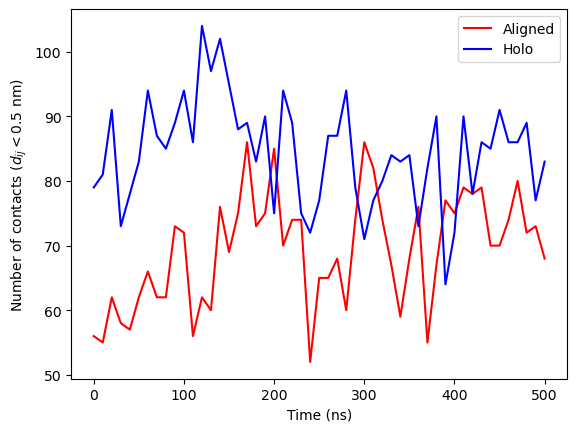

In [7]:
%pylab inline
plt.plot(apo_trj.time/1e3,apo_contacts,label="Aligned",c='r')
plt.plot(holo_trj.time/1e3,holo_contacts,label="Holo",c='b')
plt.legend(loc=0)
plt.xlabel("Time (ns)")
plt.ylabel("Number of contacts ($d_{ij}<0.5$ nm)")

Text(0, 0.5, 'Number of contacts ($d_{ij}<0.5$ nm)')

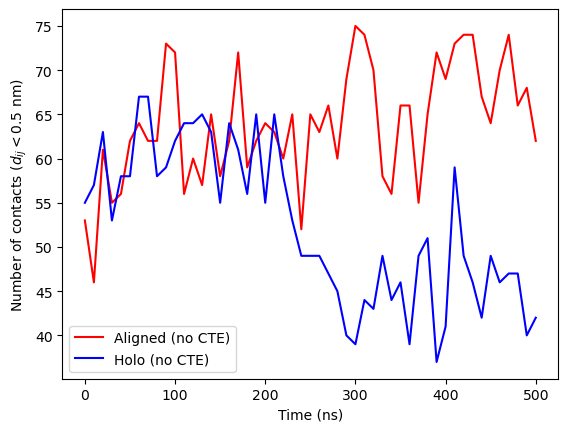

In [8]:
plt.plot(apo_trj.time/1e3,apo_contacts_noCTE,label="Aligned (no CTE)",c='r')
plt.plot(holo_trj.time/1e3,holo_contacts_noCTE,label="Holo (no CTE)",c='b')
plt.legend(loc=0)
plt.xlabel("Time (ns)")
plt.ylabel("Number of contacts ($d_{ij}<0.5$ nm)")

In [9]:
kBT=0.593

#fes_apo_top = "apo_actin_vinculin_fes_labeled.psf"
force_dirs = glob("/scratch/projects/hockygroup-archive/wpc252/projects/factin_vinculin/apo/fes/actin_apoVinc_FES_pullProj_highE*/*")
print(force_dirs)

contact_bins = np.arange(0,100,5)
apo_hist_withCTE_list = []
for force_dir in force_dirs:
    label = os.path.basename(os.path.dirname(force_dir))+'_seed'+os.path.basename(force_dir)
    xtc_file = glob(os.path.join(force_dir,"*run*.xtc"))

    if not xtc_file: 
        print("Skipping",force_dir)
    opes_file = glob(f"{force_dir}/*opes*.out")
    if len(opes_file)>1:
        print("Error, more than one opes file in",force_dir)
    else:
        opes_file = opes_file[0]
    opes_data = np.loadtxt(opes_file)
    #check for repeat rows
    repeat_lines = np.where( opes_data[1:,0]-opes_data[:-1,0] ==0 )[0] 
    opes_data = np.delete(opes_data, repeat_lines,axis=0)

    bias_trj = opes_data[::250,1]
    bias_trj-=bias_trj[0]

    frame_weights = np.exp(bias_trj/kBT)

    print(f"...Analyzing {xtc_file}")
    apo_trj = md.load(xtc_file, top=apo_eq_top,stride=10)
    contacts_withCTE = get_contacts(apo_trj,cutoff_distance=0.5)
    hist_withCTE, bins = np.histogram(contacts_withCTE,bins=contact_bins,weights=frame_weights,density=True)
    apo_hist_withCTE_list.append(hist_withCTE)


['/scratch/projects/hockygroup-archive/wpc252/projects/factin_vinculin/apo/fes/actin_apoVinc_FES_pullProj_highE_pn_0.0/34', '/scratch/projects/hockygroup-archive/wpc252/projects/factin_vinculin/apo/fes/actin_apoVinc_FES_pullProj_highE_pn_0.0/37', '/scratch/projects/hockygroup-archive/wpc252/projects/factin_vinculin/apo/fes/actin_apoVinc_FES_pullProj_highE_pn_0.0/27', '/scratch/projects/hockygroup-archive/wpc252/projects/factin_vinculin/apo/fes/actin_apoVinc_FES_pullProj_highE_pn_0.0/43', '/scratch/projects/hockygroup-archive/wpc252/projects/factin_vinculin/apo/fes/actin_apoVinc_FES_pullProj_highE_pn_0.0/41', '/scratch/projects/hockygroup-archive/wpc252/projects/factin_vinculin/apo/fes/actin_apoVinc_FES_pullProj_highE_pn_0.0/33', '/scratch/projects/hockygroup-archive/wpc252/projects/factin_vinculin/apo/fes/actin_apoVinc_FES_pullProj_highE_pn_0.0/36', '/scratch/projects/hockygroup-archive/wpc252/projects/factin_vinculin/apo/fes/actin_apoVinc_FES_pullProj_highE_pn_0.0/31', '/scratch/proje

In [10]:
force_dirs = glob("/scratch/projects/hockygroup-archive/wpc252/projects/factin_vinculin/holo/fes/actin_holoVinc_FES_pullProj_highE*/*")
print(force_dirs)

contact_bins = np.arange(0,100,5)
holo_hist_withCTE_list = []
holo_hist_withoutCTE_list = []
for force_dir in force_dirs:
    label = os.path.basename(os.path.dirname(force_dir))+'_seed'+os.path.basename(force_dir)
    xtc_file = glob(os.path.join(force_dir,"*run*.xtc"))

    if not xtc_file: 
        print("Skipping",force_dir)
    opes_file = glob(f"{force_dir}/*opes*.out")
    if len(opes_file)>1:
        print("Error, more than one opes file in",force_dir)
    else:
        opes_file = opes_file[0]
    opes_data = np.loadtxt(opes_file)
    #check for repeat rows
    repeat_lines = np.where( opes_data[1:,0]-opes_data[:-1,0] ==0 )[0] 
    opes_data = np.delete(opes_data, repeat_lines,axis=0)

    bias_trj = opes_data[::250,1]
    bias_trj-=bias_trj[0]

    frame_weights = np.exp(bias_trj/kBT)

    print(f"...Analyzing {xtc_file}")
    holo_trj = md.load(xtc_file, top=holo_eq_top,stride=10)
    contacts_withCTE = get_contacts(holo_trj,cutoff_distance=0.5)
    contacts_withoutCTE = get_contacts(holo_trj,cutoff_distance=0.5,noCTE=True)

    hist_withCTE, bins = np.histogram(contacts_withCTE,bins=contact_bins,weights=frame_weights,density=True)
    hist_withoutCTE, bins = np.histogram(contacts_withoutCTE,bins=contact_bins,weights=frame_weights,density=True)

    holo_hist_withCTE_list.append(hist_withCTE)
    holo_hist_withoutCTE_list.append(hist_withoutCTE)

['/scratch/projects/hockygroup-archive/wpc252/projects/factin_vinculin/holo/fes/actin_holoVinc_FES_pullProj_highE_pn_0.0/34', '/scratch/projects/hockygroup-archive/wpc252/projects/factin_vinculin/holo/fes/actin_holoVinc_FES_pullProj_highE_pn_0.0/37', '/scratch/projects/hockygroup-archive/wpc252/projects/factin_vinculin/holo/fes/actin_holoVinc_FES_pullProj_highE_pn_0.0/27', '/scratch/projects/hockygroup-archive/wpc252/projects/factin_vinculin/holo/fes/actin_holoVinc_FES_pullProj_highE_pn_0.0/43', '/scratch/projects/hockygroup-archive/wpc252/projects/factin_vinculin/holo/fes/actin_holoVinc_FES_pullProj_highE_pn_0.0/41', '/scratch/projects/hockygroup-archive/wpc252/projects/factin_vinculin/holo/fes/actin_holoVinc_FES_pullProj_highE_pn_0.0/33', '/scratch/projects/hockygroup-archive/wpc252/projects/factin_vinculin/holo/fes/actin_holoVinc_FES_pullProj_highE_pn_0.0/36', '/scratch/projects/hockygroup-archive/wpc252/projects/factin_vinculin/holo/fes/actin_holoVinc_FES_pullProj_highE_pn_0.0/31',

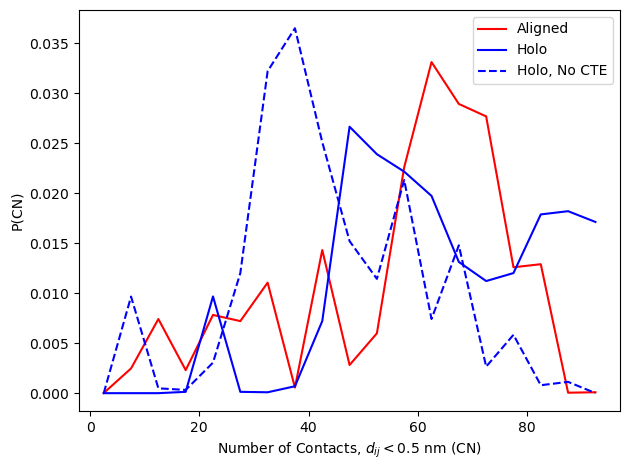

In [14]:
#plt.errorbar((contact_bins[:-1]+contact_bins[1:])/2., np.mean(apo_hist_withCTE_list,axis=0),  np.std(apo_hist_withCTE_list,axis=0)/2, label='Aligned',c='r')
#plt.errorbar((contact_bins[:-1]+contact_bins[1:])/2., np.mean(holo_hist_withCTE_list,axis=0),  np.std(holo_hist_withCTE_list,axis=0)/2, label='Holo',c='b')
#plt.errorbar((contact_bins[:-1]+contact_bins[1:])/2., np.mean(holo_hist_withoutCTE_list,axis=0),  np.std(holo_hist_withoutCTE_list,axis=0)/2, label='Holo, No CTE',c='b',linestyle='--')

plt.plot((contact_bins[:-1]+contact_bins[1:])/2., np.mean(apo_hist_withCTE_list,axis=0), label='Aligned',c='r')
plt.plot((contact_bins[:-1]+contact_bins[1:])/2., np.mean(holo_hist_withCTE_list,axis=0),  label='Holo',c='b')
plt.plot((contact_bins[:-1]+contact_bins[1:])/2., np.mean(holo_hist_withoutCTE_list,axis=0),   label='Holo, No CTE',c='b',linestyle='--')


plt.legend(loc=0)
plt.ylabel("P(CN)")
plt.xlabel("Number of Contacts, $d_{ij}<0.5$ nm (CN)")
plt.tight_layout()
plt.savefig("contact_number_histogram_fes_runs.pdf")